In [ ]:
# 3️⃣ Install the latest version along with dependencies
!pip install -U transformers datasets timm

In [ ]:
import transformers
print(transformers.__version__)

4.53.3


In [ ]:
# Step 2: Imports
# Imports
import os
import torch
import numpy as np
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, AutoFeatureExtractor, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, classification_report
from PIL import Image

In [ ]:
# Step 3: Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Step 4: Define paths
train_dir = "/content/drive/MyDrive/Brain MRI/Training"
test_dir = "/content/drive/MyDrive/Brain MRI/Testing"

In [ ]:
# Step 5: Load pretrained feature extractor
from transformers import AutoFeatureExtractor
extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
# 🟢 CHANGE 1: Add light augmentation to training data
# Augmentation
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15)
])
test_tfms = transforms.Resize((224, 224))

In [ ]:
# ✅ Fixed: Added transform support
class BrainMRIDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, extractor, transform=None):
        self.extractor = extractor
        self.dataset = datasets.ImageFolder(folder_path)
        self.classes = self.dataset.classes
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.transform:
            img = self.transform(img)
        inputs = self.extractor(images=img, return_tensors="pt")
        inputs = {k: v.squeeze() for k, v in inputs.items()}
        return {"pixel_values": inputs['pixel_values'], "label": label}


In [ ]:
# Step 7: Load datasets
train_ds = BrainMRIDataset(train_dir, extractor, train_tfms)
test_ds = BrainMRIDataset(test_dir, extractor, test_tfms)

In [ ]:
# Step 8: Load model
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=4,  # 4 tumor classes
    id2label={0: "glioma", 1: "meningioma", 2: "no_tumor", 3: "pituitary"},
    label2id={"glioma": 0, "meningioma": 1, "no_tumor": 2, "pituitary": 3}
).to(device)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 🟢 CHANGE 2: Compute metrics function
# ✅ Metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}

In [ ]:
from transformers import TrainingArguments

# ✅ TrainingArguments (works!)

training_args = TrainingArguments(
    output_dir="./vit_output",
    save_strategy="epoch",                  # ✅ still saves after each epoch
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=10,
    learning_rate=2e-5,
    load_best_model_at_end=False,           # ❌ turn this off since no eval
    save_total_limit=1,
    fp16=True
)



In [ ]:
from transformers import TrainingArguments
print(TrainingArguments)

<class 'transformers.training_args.TrainingArguments'>


In [ ]:
# Step 11: Train the model
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)


In [ ]:
history = trainer.train()

Step,Training Loss
10,1.349400
20,1.231000
30,1.077100
40,0.999400
50,0.835100
60,0.731400
70,0.713400
80,0.553800
90,0.600100
100,0.512100


In [ ]:
out = trainer.predict(test_ds)
y_true, y_pred = out.label_ids, np.argmax(out.predictions, axis=1)
print("Classification Report:\n", classification_report(y_true, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       300
           1       0.96      0.97      0.97       306
           2       0.99      0.98      0.99       405
           3       0.98      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# # Predict
# outputs = trainer.predict(test_ds)
# y_true = outputs.label_ids
# y_pred = np.argmax(outputs.predictions, axis=1)

# Accuracy & Report
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Test Accuracy: {acc * 100:.2f}%")



✅ Test Accuracy: 97.79%


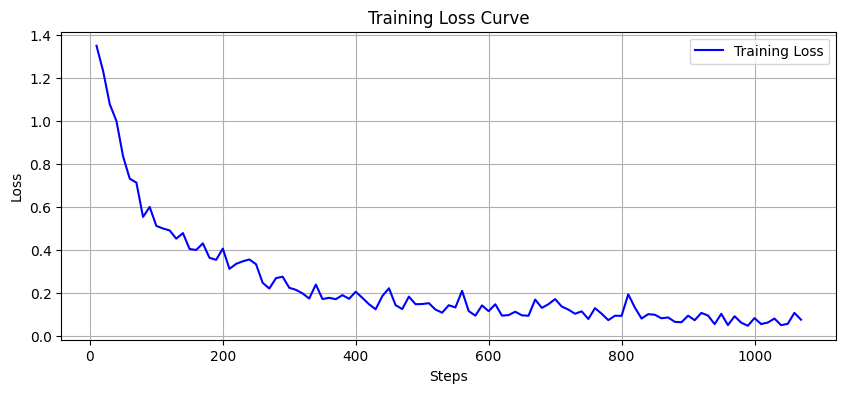

In [ ]:
import matplotlib.pyplot as plt

# Extract losses from Trainer state
steps = trainer.state.log_history
loss_steps = [(entry['step'], entry['loss']) for entry in steps if 'loss' in entry]

x_vals, y_vals = zip(*loss_steps)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(x_vals, y_vals, label="Training Loss", color="blue")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()
plt.show()


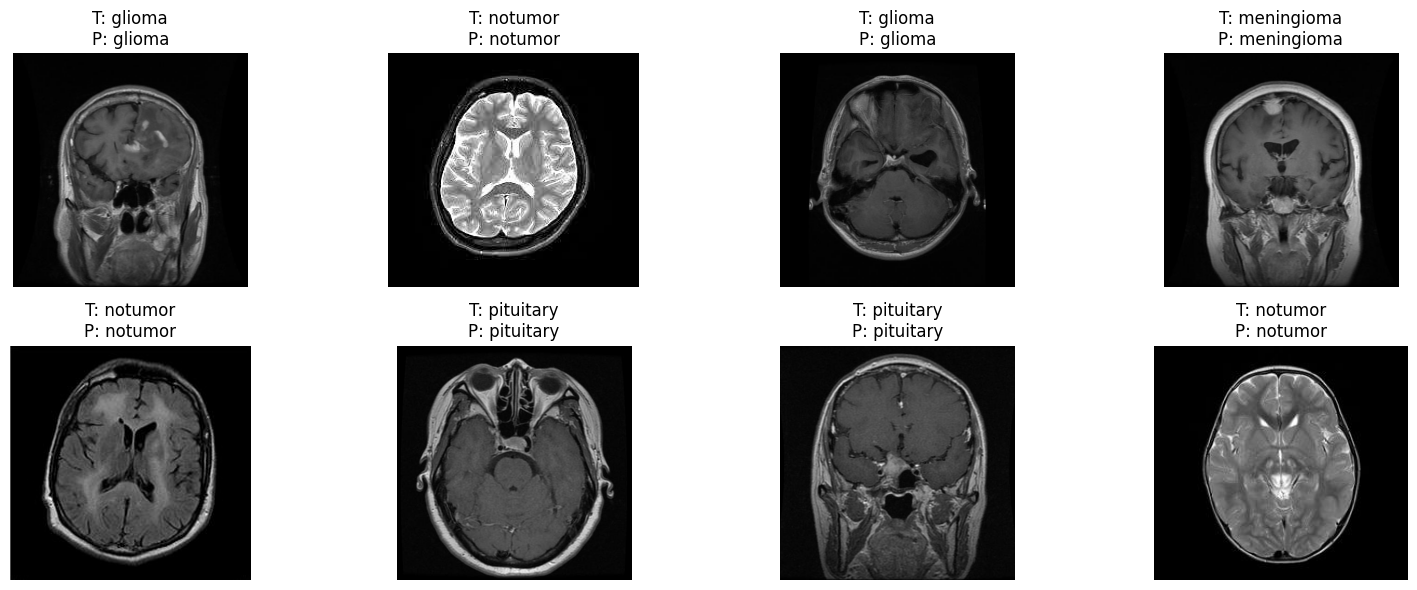

In [ ]:
import matplotlib.pyplot as plt

# Get 8 random indices
indices = np.random.choice(len(test_ds), size=8, replace=False)

# Set up plot
plt.figure(figsize=(16, 6))  # Width x Height
columns = 4

for i, idx in enumerate(indices):
    sample = test_ds[idx]
    image = test_ds.dataset[idx][0]
    true_label = test_ds.dataset.classes[sample['label']]

    pred = model(pixel_values=sample['pixel_values'].unsqueeze(0).to(device))
    pred_label_id = torch.argmax(pred.logits, dim=1).item()
    pred_label = test_ds.dataset.classes[pred_label_id]

    plt.subplot(2, columns, i + 1)
    plt.imshow(image)
    plt.title(f"T: {true_label}\nP: {pred_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
model.save_pretrained("/content/vit_brain_model")
extractor.save_pretrained("/content/vit_brain_model")


['/content/vit_brain_model/preprocessor_config.json']

In [ ]:
!zip -r vit_brain_model.zip vit_brain_model
from google.colab import files
files.download("vit_brain_model.zip")


updating: vit_brain_model/ (stored 0%)
updating: vit_brain_model/model.safetensors (deflated 7%)
updating: vit_brain_model/preprocessor_config.json (deflated 46%)
updating: vit_brain_model/config.json (deflated 52%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>